# Tutorial Session 2
Leader: Oliver Beckstein

Note: This is the **instructor copy**, for the tutorial use the **participant copy** (which is based on this copy with most of the code removed).

## Outline

￼1. trajectory processing (reading)
   - random access
   - dynamically updated trajectory data (AtomGroup.positions)
   - Examples
      - get CV timeseries and plot (AdK angles from DIMS)
      - Ramachandran analysis of trajectory (2D histogram)
      - MAYBE: velocity autocorrelation function of e.g. ions or water with scipy.fft and diffusion coefficient
      - segment trajectory based on order parameter (e.g. detect conformational transition in equilibrium AdK trajectory)
￼   - modifying coordinates
      -translation and rotation
      - RMSD superposition
         - Example: AdK domains

￼2. trajectory processing (writing)
   - writing coordinates (Writer)
   - Example: format changes (Multi PDB/XTC) and concatenation (ChainReader)

3. Bonus: interfacing with other packages
     - Examples:
        - implement LeafletFinder with networkx and analyze bilayer formation in a CGSA-MD simulation (@orbeckst)
        - pandas with MDAnalysis (@dotsdl)

        
       

## Package imports 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.display import Image

In [2]:
import MDAnalysis as mda
print(mda.__version__)

0.12.1


## Data files
Defined `datapath` to point to the directory where you [downloaded the tutorial trajectories](http://becksteinlab.github.io/MDAnalysis-workshop/datadownload.html) to.

In [3]:
import os.path
datapath = os.path.expanduser("~/Workshops/CECAM/tutorial/sandbox")

In [4]:
datapath

'/home/oliver/Workshops/CECAM/tutorial/sandbox'

## AdK test trajectories
Look again at AdK trajectories...

In [6]:
#top = os.path.join(datapath, 'equilibrium', 'adk4AKE.psf')
#trj = os.path.join(datapath, 'equilibrium', '1ake_007-nowater-core-dt240ps.dcd')

psf = os.path.join(datapath, "dims", "adk4ake.psf")
trj = os.path.join(datapath, "dims", "dims_co_001.dcd")

#coDIMS = [os.path.join(datadir, "dims", "dims_co_{0:03n}.dcd".format(i)) for i in range(1,4)] 
#ocDIMS = [os.path.join(datadir, "dims", "dims_oc_{0:03n}.dcd".format(i)) for i in range(1,4)] 

In [7]:
u = mda.Universe(top, trj)

In [8]:
u

<Universe with 3341 atoms and 3365 bonds>

## Trajectories

The `Universe.trajectory` object is the entry point to all trajectory functionality:

In [9]:
u.trajectory

< DCDReader '/home/oliver/Workshops/CECAM/tutorial/sandbox/dims/dims_co_001.dcd' with 102 frames of 3341 atoms>

Trajectories have a length in frames and in **ps** (the base MDAnalysis time unit):

In [10]:
u.trajectory.n_frames

102

In [11]:
len(u.trajectory)

102

In [12]:
u.trajectory.totaltime

101.99999383947338

### `Timestep` 

They also contain a `Timestep` object, which holds the **current**
* frame and time
* unitcell dimensions (if available) as `[A, B, C, alpha, beta, gamma]`
* raw positions (and velocities and forces, if available)
* additional data, if defined by the trajectory format

In [71]:
ts = u.trajectory.ts
ts

< Timestep 0 with unit cell dimensions [  0.   0.   0.  90.  90.  90.] >

In [14]:
ts.frame

0

In [15]:
ts.time

0.0

In [16]:
ts.dimensions

array([  0.,   0.,   0.,  90.,  90.,  90.], dtype=float32)

In [17]:
ts.positions

array([[ 26.87939835,  53.00944901,  40.99979401],
       [ 26.80416107,  52.05094147,  41.55620956],
       [ 26.58082199,  53.76752472,  41.59049988],
       ..., 
       [ 14.87982082,  56.23511505,  39.41582489],
       [ 14.59319496,  57.44499207,  39.77984619],
       [ 15.05454922,  55.95846176,  38.18389893]], dtype=float32)

In [18]:
ts.velocities

NoDataError: This Timestep has no velocities

In [19]:
ts.data

{'dt': 0.9999999396026802}

### Moving forward... or anywhere
`Universe.trajectory` behaves a bit like a list of Timesteps:
* index --> `Timestep`: go to frame
* iterate --> `Timestep`: go to each frame in sequence
* slice --> new trajectory iterator

#### Trajectory indexing

Trajectory indexing and slicing uses **0-based indices** (as in standard Python) and MDAnalysis also numbers frames starting with 0. Thus the "tenth frame" in a trajectory has ``ts.frame == 9``.

Let's move to an arbitrary frame in the trajectory:

In [20]:
u.trajectory[42]

< Timestep 42 with unit cell dimensions [  0.   0.   0.  90.  90.  90.] >

In [21]:
u.trajectory.ts.frame

42

In [22]:
u.trajectory[-23]

< Timestep 79 with unit cell dimensions [  0.   0.   0.  90.  90.  90.] >

In [23]:
u.trajectory.ts

< Timestep 79 with unit cell dimensions [  0.   0.   0.  90.  90.  90.] >

Note that you *cannot* "remember" a `Timestep`: The following will *not keep a copy of the timeset at frame 20*:

In [24]:
ts20 = u.trajectory[20]

In [25]:
ts20.frame

20

In [26]:
u.trajectory[42]

< Timestep 42 with unit cell dimensions [  0.   0.   0.  90.  90.  90.] >

In [27]:
ts20

< Timestep 42 with unit cell dimensions [  0.   0.   0.  90.  90.  90.] >

If you *really* want to, you can make a copy (but this is not used very much):

In [28]:
ts42copy = u.trajectory.ts.copy()

In [29]:
ts42copy.frame

42

In [30]:
u.trajectory[2]

< Timestep 2 with unit cell dimensions [  0.   0.   0.  90.  90.  90.] >

In [31]:
ts42copy.frame

42

#### Iteration and Slicing
The **most common usage pattern** in MDAnalysis: Access each frame in a trajectory:

In [32]:
results = []
for ts in u.trajectory:
    results.append(ts.frame)
results = np.array(results)
results

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101])

... or arbitrary slices:

In [33]:
results = np.fromiter((ts.frame for ts in u.trajectory[10::20]), dtype=np.int64)
results

array([10, 30, 50, 70, 90])

... and for numpy afficionados, "fancy indexing" also works:

In [34]:
results = np.fromiter((ts.frame for ts in u.trajectory[[10, 20, 10, 0]]), dtype=np.int64)
results

array([10, 20, 10,  0])

*Note*: It does not make sense to create a list of timesteps like
```python
timesteps = [ts for ts in u.trajectory]
```
or
```python
timesteps = list(u.trajectory)
```
because each list item will refer to the same currently active timestep (the first one because at the end of iteration the trajectory rewinds).

## Analyzing trajectories with `Atomgroup`s
Using the raw `Timestep` positions is cumbersome. Moving the time step automatically updates all positions that `Atomgroup.positions` sees at this instance:

In [44]:
u.trajectory[0]

< Timestep 0 with unit cell dimensions [  0.   0.   0.  90.  90.  90.] >

In [45]:
protein = u.select_atoms("protein")
protein

<AtomGroup with 3341 atoms>

Calculate the radius of gyration
\begin{equation*}
    R_{\text{gyr}} = \sqrt{\frac{1}{M}\sum_{i=1}^{N}m_{i}(\textbf{r}_{i} - \textbf{R})^{2}}
\end{equation*}
 with `AtomGroup.radius_of_gyration()`:

In [46]:
protein.radius_of_gyration()

16.686297031597615

What's the current frame?

In [47]:
u.trajectory.ts.frame

0

Move to the last one:

In [50]:
u.trajectory[-1]

< Timestep 101 with unit cell dimensions [  0.   0.   0.  90.  90.  90.] >

In [51]:
protein.radius_of_gyration()

19.579294280925577

Remember: **All coordinate-dependent properties of an `AtomGroup` change when the trajectory index is changed.** Think of a pointer moving along the trajectory file. `AtomGroup` fetches coordinates from the frame that the pointer points to.

#### Example: radius of gyration time series
Collect `(time, radius_of_gyration)` for the protein for frames 0 - 500 and plot $R_{\mathrm{gyr}}(t)$, with time in ps.

In [52]:
protein = u.select_atoms("protein")
results = []
for ts in u.trajectory[:500]:
    results.append((ts.time, protein.radius_of_gyration()))
time, rgyr = np.transpose(results)

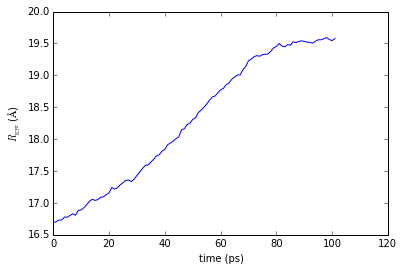

In [54]:
ax = plt.subplot(111)
ax.plot(time, rgyr)
ax.set_xlabel("time (ps)")
ax.set_ylabel(r"$R_{\mathrm{gyr}}$ ($\AA$)")

#### Exercise: Collective variable analysis of AdK

1. Generate timeseries for domain angles, i.e. $t$, $\theta_\mathrm{NMP}(t)$, $\theta_\mathrm{LID}(t)$, using the previously defined functions `theta_NMP()` and `theta_LID()`.
2. Plot (a) the time series, (b) the angles against each other.
3. Bonus: 
   - analyze some of the other trajectories
   - is the radius of gyration correlated with the angles?

In [55]:
import numpy as np
from numpy.linalg import norm

def theta_NMP(ag):
    """Calculate the NMP-CORE angle for E. coli AdK in degrees"""
    C = ag.select_atoms("resid 115:125 and backbone").center_of_geometry()
    B = ag.select_atoms("resid 90:100 and backbone").center_of_geometry()
    A = ag.select_atoms("resid 35:55 and backbone").center_of_geometry()
    BA = A - B
    BC = C - B
    theta = np.arccos(np.dot(BA, BC)/(norm(BA)*norm(BC)))
    return np.rad2deg(theta)

def theta_LID(ag):
    """Calculate the LID-CORE angle for E. coli AdK in degrees"""
    C = ag.select_atoms("resid 179:185 and backbone").center_of_geometry()
    B = ag.select_atoms("resid 115:125 and backbone").center_of_geometry()
    A = ag.select_atoms("resid 125:153 and backbone").center_of_geometry()
    BA = A - B
    BC = C - B
    theta = np.arccos(np.dot(BA, BC)/(norm(BA)*norm(BC)))
    return np.rad2deg(theta)

In [57]:
data = np.array([[ts.time, theta_NMP(u), theta_LID(u)] for ts in u.trajectory])

In [58]:
data[:3]

array([[   0.        ,   43.29564285,  106.30675507],
       [   0.99999994,   44.1594696 ,  106.80901337],
       [   1.99999988,   44.57506561,  108.23643494]])

In [59]:
time, aNMP, aLID = data.transpose()

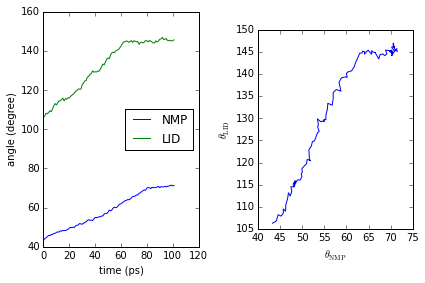

In [61]:
ax1 = plt.subplot(121)
ax1.plot(time, aNMP, label="NMP")
ax1.plot(time, aLID, label="LID")
ax1.set_xlabel("time (ps)")
ax1.set_ylabel("angle (degree)")
ax1.legend(loc="best")
ax2 = plt.subplot(122)
ax2.plot(aNMP, aLID)
ax2.set_xlabel(r"$\theta_\mathrm{NMP}$")
ax2.set_ylabel(r"$\theta_\mathrm{LID}$")
ax2.set_aspect(1)
plt.tight_layout()

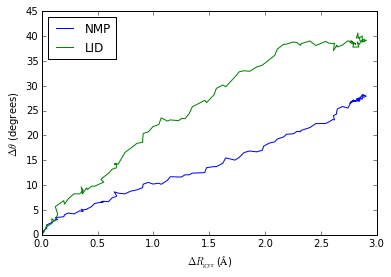

In [70]:
ax = plt.subplot(111)
ax.plot(rgyr-rgyr[0], aNMP-aNMP[0], label="NMP")
ax.plot(rgyr-rgyr[0], aLID-aLID[0], label="LID")
ax.set_xlabel(r"$\Delta R_\mathrm{gyr}$ ($\AA$)")
ax.set_ylabel(r"$\Delta\theta$ (degrees)")
ax.legend(loc="best")


## Trajectory manipulation

One can easily modify the coordinates of the current timestep: Either directly in `Timestep.positions` or via `AtomGroup` methods such as `translate` or `rotate`.

In particular, we can do RMSD fitting.


## Writing trajectories and selections
Writing out coordinates; introduce the selection writer (cross package).

### Trajectory Writer
Basic pattern:
1. get a trajectory writer
   - use `with` and context manager
   - provide `n_atoms` (typically from the `AtomGroup` that you are going to write)
   - can use `format` keyword argument if extension is not recognized
2. iterate through a trajectory
3. `write()` each time step (or `AtomGroup`)
4. (close trajectory --- done by context manager)

Converting trajectory formats:

In [81]:
xtc = "new.xtc"
with mda.Writer(xtc, n_atoms=u.atoms.n_atoms) as W:
    for ts in u.trajectory:
        W.write(ts)

In [83]:
!ls -l *.xtc 

-rw-r--r-- 1 oliver oliver 1296904 Oct 13 15:01 new.xtc


In [84]:
uxtc = mda.Universe(psf, xtc)
uxtc

<Universe with 3341 atoms and 3365 bonds>

In [85]:
import os
os.unlink(xtc)

### Selections for other packages
To increase interoperability you can also write a MDAnalysis selection in a format understood by other packages such as Gromacs, VMD, PyMOL, ...

In [123]:
acidic = u.select_atoms("((resname GLU or resname ASP) and (name OD* or name OE*))")
basic = u.select_atoms( "((resname LYS or resname ARG) and (name NZ or name NH*))")

acidic_res = u.select_atoms("group acidic and around 4 group basic", acidic=acidic, basic=basic).residues
basic_res = u.select_atoms("group basic and around 4 group acidic", acidic=acidic, basic=basic).residues

(acidic_res + basic_res).write("sb.vmd", name="sb")

Then load into VMD
```
source sb.vmd
```
and use the new named selection "sb" in *Representations*.

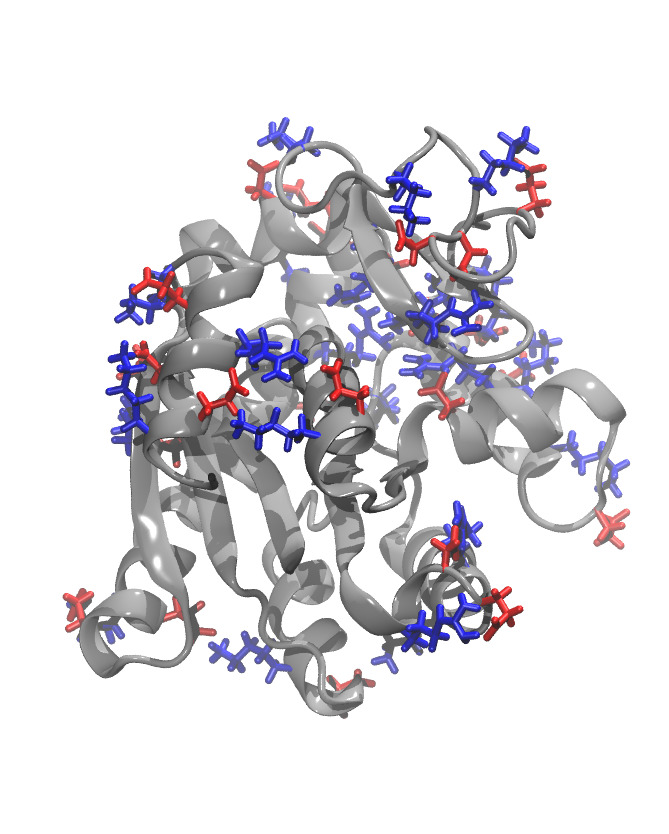

In [121]:
Image("./figs/adk_closed_saltbridges.jpg", width=400)

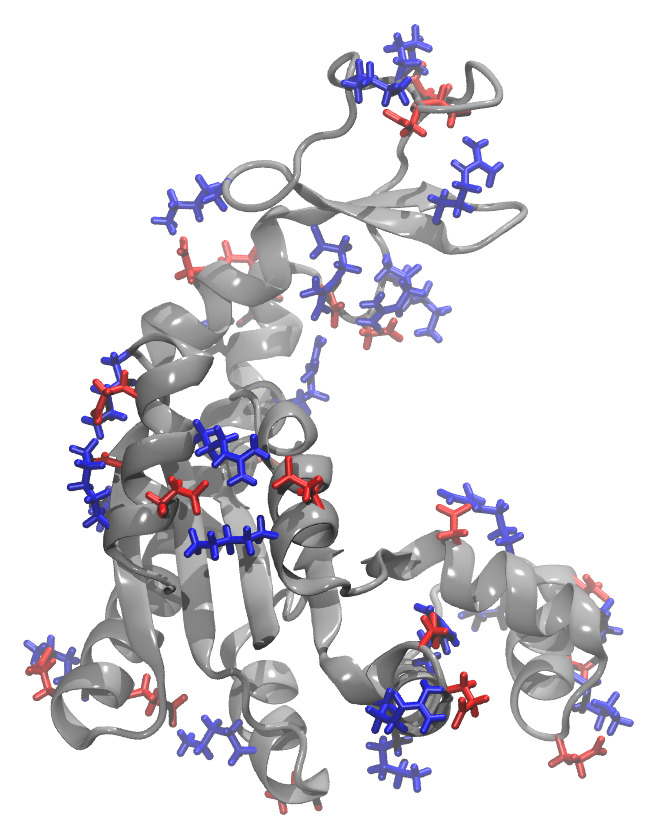

In [122]:
Image("./figs/adk_open_saltbridges.jpg", width=400)

## Extra 